In [9]:
import math
import matplotlib.pyplot as plt
import heapq

from signal_generator import SignalGenerator
from metrics import Metric
from data_type import Measurement

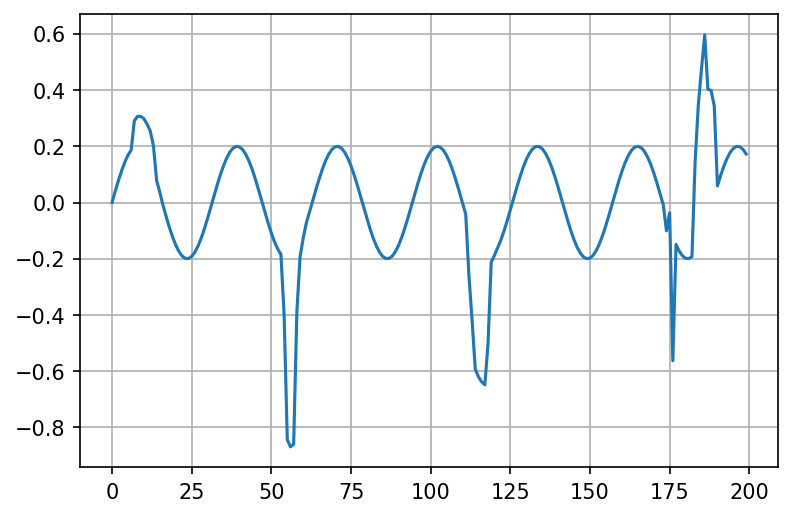

In [52]:
SignalGenerator(0, 200).with_peaks(3).with_peaks(3, direction=-1).sin(0.2, 0.2).draw()

In [55]:
v = Metric().corelation_spearman([1,2,3,4,5,6,7,8,9], [1,1,1,-5,5,6,7,4,11], False)
print(v)

[-5, 1, 1, 1, 4, 5, 6, 7, 11]
0.9083333333333333


{'original_size': 100, 'compressed_size': 104, 'compression_rate': -0.04}


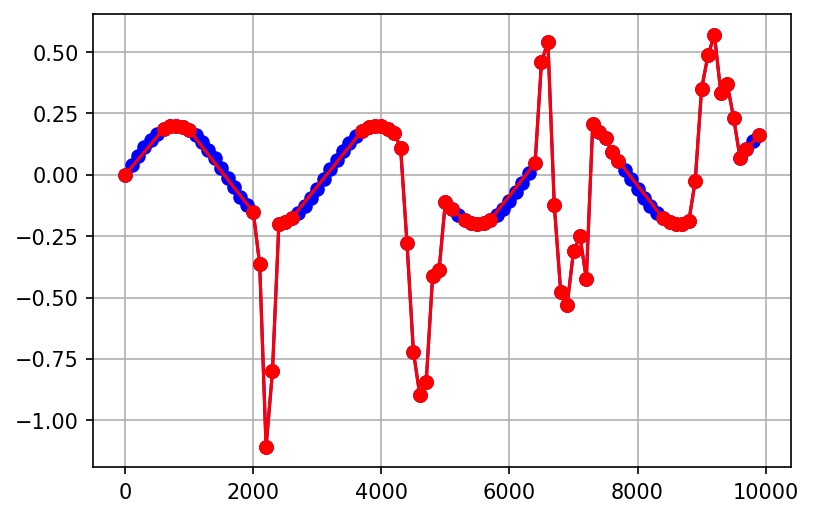

In [11]:
class DataCompressor:
  metric: Metric = Metric()
  original_data: list[Measurement] = []
  compressed_data: list[Measurement] = []

  # todo: create class
  compress_nths_conf = {
    'n': 3
  }

  # todo: create class
  compress_higher_deriveration_conf = {
    'deriveration': 0.05
  }

  # todo: create class
  compress_by_chunk_conf = {
    'chunk_size': 5
  }

  # todo: create class
  compress_min_max_conf = {
    'points_count': 30,
    'points_part': 0.5,
    'use_points_count': False
  }

  # todo: create class
  compress_with_density_conf = {

  }

  # todo: create class
  perceptual_interesting_points_conf = {
    'compress_ration': 0.5
  }

  stc_conf = {
    'slope_angle': 0.4
  }

  def __init__(self): # metrics config, compression config
    pass # todo
  
  def _fill_with_interpolate(self):
    pass # todo
  
  def valid(self):
    pass # todo

  def compress_nths(self):
    data_len = len(self.original_data)
    for i in range(0, data_len, self.compress_nths_conf['n']):
      self.compressed_data.append(self.original_data[i])
    if data_len % 3 != 0:
      self.compressed_data.append(self.original_data[data_len - 1])
    return self.compressed_data

  def compress_higher_deriveration(self):
    deriveration = self.compress_higher_deriveration_conf['deriveration']
    if len(self.original_data) == 0:
      return
    last_measurement_value = self.original_data[0].value
    for measurement in self.original_data:
      if abs(last_measurement_value - measurement.value) > deriveration:
        self.compressed_data.append(measurement)
        last_measurement_value = measurement.value

  def compress_by_chunk(self):
    chunk_size = self.compress_by_chunk_conf['chunk_size']
    if chunk_size < 1:
      return
    chunk: list[Measurement] = []
    for index, measurement in enumerate(self.original_data):
      if index != 0 and index % chunk_size == 0:
        value_average = chunk[0].value
        timestamp_average = chunk[0].timestamp
        for chunk_index in range(1, len(chunk)):
          value_average = (value_average + chunk[chunk_index].value) / 2
          timestamp_average = (timestamp_average + chunk[chunk_index].timestamp) / 2
        self.compressed_data.append(Measurement(value_average, round(timestamp_average)))
        chunk = []
      else:
        chunk.append(measurement)
    if len(chunk) != 0:
      for item in chunk:
        value_average = (value_average + item.value) / 2
        timestamp_average = (timestamp_average + item.timestamp) / 2
        self.compressed_data.append(Measurement(value_average, round(timestamp_average)))

  def compress_min_max(self):
    if len(self.original_data) == 0:
      return
    config = self.compress_min_max_conf
    if config['use_points_count']:
      points_count = config['points_count']
    else:
      points_count = round(len(self.original_data) * config['points_part'])
    if points_count < 1:
      return
    compressed_measurements_set = set()
    measurements = set(self.original_data)
    for _ in range(round(points_count / 2)):
      min_measurement = next(iter(measurements))
      max_measurement = next(iter(measurements))
      for measurement in measurements:
        if min_measurement.value > measurement.value:
          min_measurement = measurement
        if max_measurement.value < measurement.value:
          max_measurement = measurement
      measurements.remove(min_measurement)
      measurements.remove(max_measurement)
      compressed_measurements_set.add(min_measurement)
      compressed_measurements_set.add(max_measurement)
    self.compressed_data = sorted(compressed_measurements_set, key=lambda measurement: measurement.timestamp)
  
  def _euqlides_distance(self, point_a: tuple[int, float], point_b: tuple[int, float]) -> float:
    return math.sqrt((point_a[0] - point_b[0]) ** 2 + (point_a[1] - point_b[1]) ** 2)

  # paper
  # PIP - perceptual interesting points
  def compress_perceptual_interesting_points(self): 
    config = self.perceptual_interesting_points_conf
    points_count = config['compress_ration'] * len(self.original_data)
    last_index = len(self.original_data) - 1
    indexes = [0, last_index]
    heap = []
    heapq.heappush(heap, (-len(self.original_data), 0, last_index))
    
    while len(heap) != 0 and len(indexes) < points_count:
      _, index_start, index_end = heapq.heappop(heap)
      measurement = self.original_data[index_start]
      point_start = (measurement.timestamp, measurement.value)
      measurement = self.original_data[index_end]
      point_end = (measurement.timestamp, measurement.value)
      max_distance_index = index_start
      max_distance = 0
      if index_start + 1 == index_end:
        continue
      # todo: sortowanie po wielkosci przedziału w kolejce
      for i in range(index_start + 1, index_end):
        measurement = self.original_data[i]
        current_point = (measurement.timestamp, measurement.value)
        distance = self._euqlides_distance(point_start, current_point) + self._euqlides_distance(point_end, current_point)
        if distance > max_distance:
          max_distance = distance
          max_distance_index = i
      indexes.append(max_distance_index)
      heapq.heappush(heap, (-(max_distance_index - index_start), index_start, max_distance_index))
      heapq.heappush(heap, (-(index_end - max_distance_index), max_distance_index, index_end))

    for i in sorted(indexes):
      self.compressed_data.append(self.original_data[i])

  # paper
  # STC - Piecewise Linear Representation of Time Series based on Slope Change Threshold
  # 1-s2.0-S1875389212006219-main
  def compress_stc(self):
    if len(self.original_data) == 0:
      return
    if len(self.original_data) < 4:
      self.compressed_data = self.original_data
    slope_angle_d = self.stc_conf['slope_angle']

    output = [self.original_data[0]]
    for i in range(2, len(self.original_data)):
      point_a = self.original_data[i - 2]
      point_b = self.original_data[i - 1]
      point_c = self.original_data[i]
      slope_angel_ab = (point_b.value - point_a.value) / (point_b.timestamp - point_a.timestamp)
      slope_angel_cb = (point_c.value - point_b.value) / (point_c.timestamp - point_b.timestamp)
      ratio = abs(slope_angel_ab / slope_angel_cb - 1)
      if ratio > slope_angle_d:
        output.append(point_b)
        output.append(point_c)

    if output[len(output) - 1].timestamp != self.original_data[len(self.original_data) - 1].timestamp:
      output.append(self.original_data[len(self.original_data) - 1])
    self.compressed_data = output

  def compress_stc_v2(self):
    # todo
    # nie brać tylko dwóch pod uwagę a dłuższe ramie
    pass

  def compress_random(self):
    # todo
    pass

  def compress_with_density(self):
    # todo
    pass

  def compress_with_corelation(self):
    # todo
    pass

  def compress_minimum_for_metric(self):
    # todo
    pass

  def compress(self):
    # todo: check metrics
    self.compress_stc()

  def push(self, measurement: Measurement):
    self.original_data.append(measurement)
  
  def set_data(self, measurements: list[Measurement]):
    self.original_data = measurements

  def clean_data(self):
    self.original_data = []
    self.compressed_data = []

  def vizualize(self, show_compressed: bool = True, show_interpolation: bool = False):
    x_original = [measurement.timestamp for measurement in self.original_data]
    y_original = [measurement.value for measurement in self.original_data]
    plt.figure(dpi=150)
    if show_interpolation:
        plt.plot(x_original, y_original, 'b')
    plt.plot(x_original, y_original, 'bo')
    if show_compressed:
      x_compressed = [measurement.timestamp for measurement in self.compressed_data]
      y_compressed = [measurement.value for measurement in self.compressed_data]
      if show_interpolation:
        plt.plot(x_compressed, y_compressed, 'r')
      plt.plot(x_compressed, y_compressed, 'ro')
    plt.grid()
    plt.show()
    return self

  def get_data(self):
    return [measurement.value for measurement in self.compressed_data]

  def get_stats(self):
    return {
      'original_size': len(self.original_data),
      'compressed_size': len(self.compressed_data),
      'compression_rate': (len(self.original_data) - len(self.compressed_data)) / len(self.original_data)
    }

signal_generator = SignalGenerator(0, 100).with_peaks(3).with_peaks(3, direction=-1).sin(0.2, 0.2)
# signal_generator = SignalGenerator(0, 100).sin(5, 0.2).noise()
# signal_generator = SignalGenerator(0, 100).with_peaks(3)
# signal_generator.draw()
data_compressor = DataCompressor()

for index, measurement in enumerate(signal_generator.data):
  data_compressor.push(Measurement(measurement, index * 100))
# data_compressor.set_data([Measurement(i, i*100) for i in range(20)])
data_compressor.compress()
print(data_compressor.get_stats())
data_compressor.vizualize(True, True)

In [8]:
import unittest
from tests_.basic import *

unittest.main(argv=[''], verbosity=2, exit=False)

test_isupper (tests_.basic.TestStringMethods) ... ok
test_split (tests_.basic.TestStringMethods) ... ok
test_upper (tests_.basic.TestStringMethods) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.002s

OK
